# Visualize Internals

**Goal:** Where are we _losing_ the info in the model?

Let's make all the plots!!

**Step 1:** Are we losing info with the way we're adding the position?

**Plan:** Plot the variables for x,y,z in the features.

In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# IO pkgs
import yaml, json
from glob import glob

# custom code
import os
os.sys.path.append('code')
from plotting import plot_kslots, plot_kslots_iters
from data import make_batch
from model import SlotAttentionPosEmbed

%load_ext autoreload
%autoreload 2

In [2]:
device = 'cpu'

In [3]:
'''
Take a trained model -- for starters the model with Q=16,
although then we can scale up to 126
'''

cID = '2rings-sqrtD'
config = f'code/configs/{cID}.yaml'

with open(config, "r")as cfile:
    cdict = yaml.safe_load(cfile)

opt = cdict["opt"]
hps = cdict["hps"]
kwargs = cdict["data"] # to pass to the data loading fct

In [4]:
hps['device'] = device
model = SlotAttentionPosEmbed(**hps).to(device)

In [5]:
# Load in the weights 
# Check for what was the last training iteration
modelChkpts = glob(f'code/models/{cID}/m_*.pt')
if len(modelChkpts) == 0:
    print('ERROR -- No files fround for',modelChkpts, 'when requesting to train from warm_start')
    raise FileNotFoundError

savedIters = [mName.split('/')[-1].split('.')[0].split('_')[-1] for mName in modelChkpts   ]
savedIters = np.array([int(i) for i in savedIters])                     
lastIter = np.max(savedIters)

print(f'Starting from an earlier training',lastIter)

modelToLoad = f'code/models/2rings-sqrtD/m_{lastIter}.pt'

Starting from an earlier training 488000


In [6]:
model.load_state_dict(torch.load(modelToLoad,map_location=device))

<All keys matched successfully>

**Generate a mini-batch of data**

In [7]:
np.random.seed(22082023)

In [8]:
bs = 10

X, Y, mask = make_batch(N_events=bs, device=device, **kwargs)

/gpfs/slac/atlas/fs1/d/nhartman/Slot Attention/code/data.py:97: RuntimeWarning: invalid value encountered in true_divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


**Before starting, I'm a little curious which examples were well classified?**

**Get the CNN representation**

In [9]:
posEnc = model.posEnc

In [10]:
lin_proj_4x32 = posEnc.dense
grid = posEnc.grid

In [11]:
with torch.no_grad():
    cnn_feat = model.CNN_encoder(X).permute(0,2,3,1) # with channel dim at th end
    grid_feat = lin_proj_4x32(grid)

In [12]:
cnn_feat.flatten()

tensor([ 2.5185, -2.5887,  2.6897,  ..., -0.1787, -2.1789,  2.5023])

In [13]:
cnn_feat.shape

torch.Size([10, 32, 32, 16])

In [14]:
grid.shape

torch.Size([1, 32, 32, 4])

In [15]:
grid_feat.shape

torch.Size([1, 32, 32, 16])

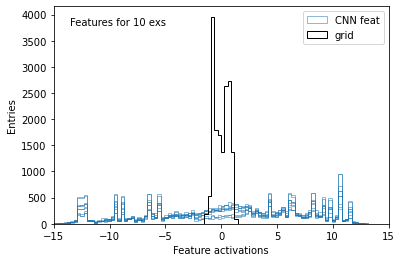

In [16]:
nb = 100
r = (-15,15)

for i in range(10):
    plt.hist(cnn_feat[i].flatten().numpy(),nb,r,
             label='CNN feat' if i ==0 else None,
             histtype='step',alpha=.5,color='C0')
plt.hist(grid_feat.flatten().numpy(),nb,r,color='k',
         histtype='step',label='grid')

ax = plt.gca()
plt.text(.05,.95,'Features for 10 exs',transform=ax.transAxes,va='top')
plt.legend()
plt.xlabel('Feature activations')
plt.ylabel('Entries')
plt.xlim(r)

plt.show()

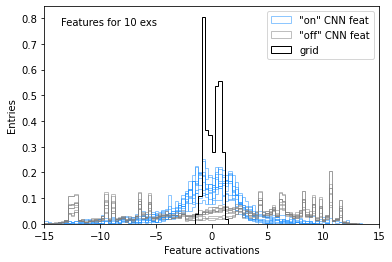

In [17]:
nb = 100
r = (-15,15)

for i in range(10):
    plt.hist(cnn_feat[i][mask[i].sum(dim=0).bool()].flatten().numpy(),nb,r,
             label='"on" CNN feat' if i ==0 else None,
             histtype='step',alpha=.5,color='dodgerblue',density=True)
    plt.hist(cnn_feat[i][~mask[i].sum(dim=0).bool()].flatten().numpy(),nb,r,
             label='"off" CNN feat' if i ==0 else None,
             histtype='step',alpha=.5,color='grey',density=True)
plt.hist(grid_feat.flatten().numpy(),nb,r,color='k',
         histtype='step',label='grid',density=True)

ax = plt.gca()
plt.text(.05,.95,'Features for 10 exs',transform=ax.transAxes,va='top')
plt.legend()
plt.xlabel('Feature activations')
plt.ylabel('Entries')
plt.xlim(r)

plt.show()

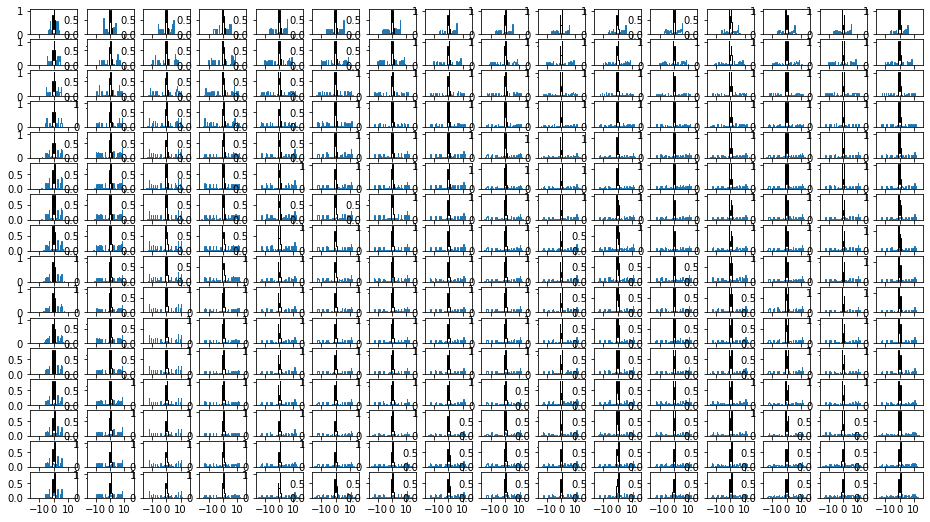

In [18]:
fig, axes = plt.subplots(16,16,figsize=(16,9))

for i,ax_list in enumerate(axes):
    for j,ax in enumerate(ax_list):
        
        ax.hist(cnn_feat[:,i,j].numpy().flatten(),nb,r,color='C0',histtype='step',density=True)
        ax.hist(grid_feat[:,i,j].numpy().flatten(),nb,r,color='k',histtype='step',density=True)
        
        # ax.axis('off')
        
    #     break
    # break
    
plt.show() 

^ And... this is only the upper left corner of the image

**Note:** It might be nice to have a "by eye" comparison of the "good" and "bad" examples, and then color code the histograms.

In [19]:
mask.sum(dim=1).bool().shape

torch.Size([10, 32, 32])

In [20]:
X.shape

torch.Size([10, 1, 32, 32])

In [21]:
torch.log(X.squeeze()[mask.sum(dim=1).bool()])

tensor([0.6931, 3.9890, 3.9512, 3.9890, 3.4657, 2.1972, 4.1431, 2.8332, 3.9120,
        3.6889, 3.5553, 2.9957, 3.8286, 3.6376, 3.7842, 3.8712, 3.9703, 3.5553,
        2.5649, 1.6094, 4.0431, 1.7918, 3.3673, 3.7612, 3.9318, 3.7612, 3.9318,
        3.1355, 0.6931, 3.4012, 3.2189, 3.7136, 3.2581, 3.5553, 3.2189, 2.9957,
        3.0910, 1.3863, 3.6109, 1.3863, 3.3322, 3.6376, 3.3673, 1.9459, 2.7726,
        3.4340, 3.3673, 3.2581, 3.4340, 3.4340, 3.4657, 3.2189, 3.4012, 3.2958,
        1.0986, 3.3322, 1.6094, 3.7842, 2.3979, 3.2189, 1.3863, 3.6376, 2.3979,
        3.0910, 3.2581, 2.7726, 3.3673, 3.3673, 2.8332, 3.1781, 1.3863, 3.8286,
        4.0254, 3.7842, 0.0000, 2.3026, 4.0073, 0.0000, 4.1271, 2.8332, 3.9318,
        3.8286, 3.9890, 3.4012, 3.8712, 3.7612, 3.8067, 3.9318, 2.9444, 3.8067,
        3.8712, 2.9957, 2.0794, 4.0943, 3.8918, 3.8501, 2.5649, 2.4849, 3.0910,
        3.0445, 2.7726, 3.1781, 3.3673, 3.4965, 2.5649, 3.2581, 2.5649, 2.3979,
        3.6376, 2.0794, 3.2958, 3.2189, 

In [22]:
log_occ = torch.log(X.squeeze()[mask.sum(dim=1).bool()])

In [23]:
X.shape

torch.Size([10, 1, 32, 32])

In [24]:
torch.cat([X,torch.tile(grid.permute(0,3,1,2), [X.shape[0],1,1,1])],dim=1).shape

torch.Size([10, 5, 32, 32])

In [25]:
import pandas as pd

code/models/2rings-sqrtD-Q128/loss.json
255001 [0.0331678  0.03310864 0.03306845]
code/models/pixel_mult/loss.json
464001 [0.026384   0.02638564 0.02635029]
code/models/pos_inpts/loss.json
461001 [0.03525669 0.03522478 0.03520164]
code/models/pos_inpts_logE/loss.json
477001 [0.02629015 0.02627349 0.02625271]


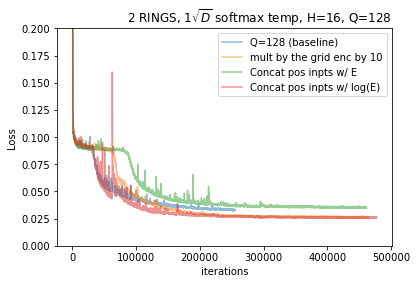

In [26]:
alpha=.5
roll_avg=100
for cid,l,c in zip(['2rings-sqrtD-Q128','pixel_mult','pos_inpts','pos_inpts_logE'],
                 ['Q=128 (baseline)',
                  'mult by the grid enc by 10',
                  'Concat pos inpts w/ E',
                  'Concat pos inpts w/ log(E)'],
                  ['C0','C1','C2','forestgreen']):
    
    fname = f'code/models/{cid}/loss.json'
    print(fname)
    try:
        with open(fname) as f:
            ld = pd.Series(json.load(f))
        print(len(ld),ld.rolling(roll_avg).mean()[-3:].values)
        plt.plot(ld.rolling(roll_avg).mean()[roll_avg:],
                 label=l,alpha=alpha)

    except FileNotFoundError:
        print(f'^ this file doesn\'t exist yet')

        
        
plt.title('2 RINGS, $1\sqrt{D}$ softmax temp, H=16, Q=128',loc='right')
plt.xlabel('iterations')
plt.ylabel('Loss')
# plt.xlim(0,260_000)
plt.ylim(0,.2)
plt.legend()

In [27]:
hidden_dim=64
cnn_args = {
    'out_channels': hidden_dim,
    'kernel_size': 5,
    'padding':2, # same
}

num_conv_layers=4

CNN_encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, **cnn_args),
            *( [torch.nn.ReLU(), torch.nn.Conv2d(hidden_dim,**cnn_args)] * (num_conv_layers-1)))
        

In [28]:
.25*3

0.75

In [29]:
CNN_encoder

Sequential(
  (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (3): ReLU()
  (4): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (5): ReLU()
  (6): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)

**Sanity check the model works!**

**Add positional features**

In [30]:
bs = 10

X, Y, mask = make_batch(N_events=bs, device=device, **kwargs)

/gpfs/slac/atlas/fs1/d/nhartman/Slot Attention/code/data.py:97: RuntimeWarning: invalid value encountered in true_divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


(array([ 92.,  73., 108., 169., 118.,  49.,  13.,   3.,   2.,   3.]),
 array([ 1. ,  8.3, 15.6, 22.9, 30.2, 37.5, 44.8, 52.1, 59.4, 66.7, 74. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

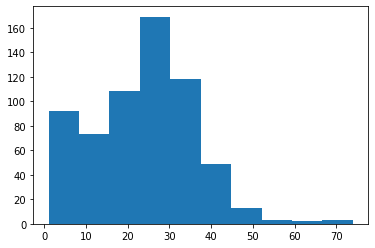

In [31]:
plt.hist(X.squeeze()[mask.sum(dim=1).bool()].numpy())

(array([ 18.,  12.,  11.,  16.,  35.,  49., 105., 215., 158.,  11.]),
 array([0.       , 0.4304065, 0.860813 , 1.2912196, 1.721626 , 2.1520326,
        2.5824392, 3.0128458, 3.443252 , 3.8736587, 4.304065 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

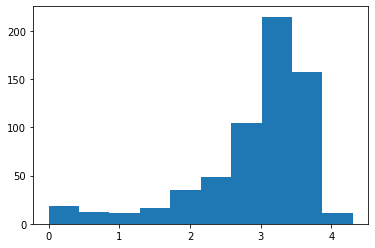

In [32]:
plt.hist(torch.log(X.squeeze()[mask.sum(dim=1).bool()]).numpy())

In [33]:
X2, Y2, mask2 = make_batch(N_events=bs, device=device, logE=True, **kwargs)

/gpfs/slac/atlas/fs1/d/nhartman/Slot Attention/code/data.py:103: RuntimeWarning: divide by zero encountered in log
  eventHistograms = np.where(eventHistograms>0,np.log(eventHistograms),0)


(array([ 12.,  12.,  11.,  22.,  33.,  56.,  88., 192., 149.,  22.]),
 array([0.        , 0.43307334, 0.8661467 , 1.29922   , 1.7322934 ,
        2.1653666 , 2.59844   , 3.0315132 , 3.4645867 , 3.89766   ,
        4.3307333 ], dtype=float32),
 [<matplotlib.patches.Polygon at 0x7fb1f37834c0>])

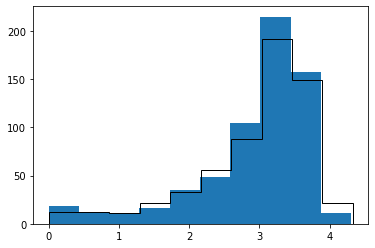

In [34]:
plt.hist(torch.log(X.squeeze()[mask.sum(dim=1).bool()]).numpy())
plt.hist(X2.squeeze()[mask2.sum(dim=1).bool()].numpy(),histtype='step',color='k')

It's not exactly the same b/c I don't have the same random seed, but the distributions roughly match... I think my implementation is  good!

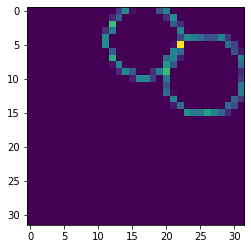

In [35]:
plt.imshow(X[0,0].numpy())

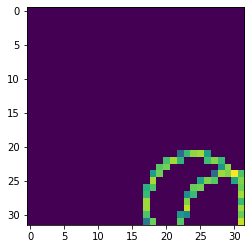

In [36]:
plt.imshow(X2[0,0].numpy())